In [1]:
from cocpit.plotting_scripts import gewitter_functions
from cocpit.plotting_scripts import performance_diagrams
import cocpit
import torch
import numpy as np
from sklearn.metrics import confusion_matrix
import tqdm
from cocpit import config as config
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2


In [169]:
plt_params = {
    "axes.labelsize": "medium",
    "axes.titlesize": "medium",
    "xtick.labelsize": "medium",
    "ytick.labelsize": "medium",
    "legend.title_fontsize": 10,
}
plt.rcParams["font.family"] = "serif"
plt.rcParams.update(plt_params)

In [2]:
#  make predictions on each batch of images,
#  and concatenate the precitions across batches
p = cocpit.predictions.LoaderPredictions()
with torch.no_grad():
    for fold in range(config.KFOLD+1):
        model = p.load_model(fold)
        val_loader = p.load_val_loader(fold)
        for ((imgs, labels, paths), batch) in val_loader:
            b = cocpit.predictions.BatchPredictions(imgs, model)
            b.find_max_preds()
            b.top_k_preds(len(config.CLASS_NAMES))
            p.append_batch(b, paths, labels)
p.concatenate_loader_vars()
yhat = p.max_preds
y_validate = [i.item() for i in p.labels]

In [3]:
yhat_proba = np.zeros((len(config.CLASS_NAMES),len(p.topk_probs)))
for i in range(len(p.topk_probs)):
    for c in range(len(config.CLASS_NAMES)):
        yhat_proba[c, i] = p.topk_probs[i][np.where(np.array(p.topk_classes[i]) == c)[0][0]]
yhat_proba[0,:]

array([9.95630383e-01, 9.92998958e-01, 9.99979019e-01, ...,
       9.78944286e-07, 9.98718858e-01, 9.99907255e-01])

100%|██████████| 100/100 [00:02<00:00, 45.19it/s]


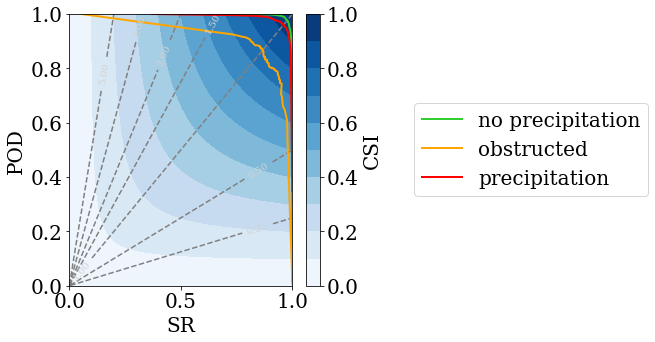

In [11]:
threshs = np.linspace(0.0,1.0,100)
pl = [i.item() for i in p.labels] #torch to value

pods = np.zeros((len(config.CLASS_NAMES), len(threshs)))
srs = np.zeros((len(config.CLASS_NAMES), len(threshs)))

ax = gewitter_functions.make_performance_diagram_axis()
markerfacecolor = ['limegreen', 'orange', 'r']
for c, _ in enumerate(config.CLASS_NAMES):
    y_preds = yhat_proba[c,:]
    
    #for each threshold
    for i,t in enumerate(tqdm.tqdm(threshs)):
        #make a dummy binary array full of 0s
        if c == 0:
            y_preds_bi = np.ones(len(y_preds),dtype=int)
        else:
            y_preds_bi = np.zeros(len(y_preds),dtype=int)
        #find where the prediction is greater than or equal to the threshold
        idx = np.where(y_preds >= t)
        #set those indices to class label
        y_preds_bi[idx] = c
        #get the contingency table again 
        table = gewitter_functions.get_contingency_table(len(config.CLASS_NAMES), id=c, ol=np.array(p.labels), pl=np.array(y_preds_bi))
        
        #calculate pod, sr and csi 
        pods[c,i] = gewitter_functions.get_pod(table)
        srs[c,i] = gewitter_functions.get_sr(table)
    ax.plot(srs[c,:],pods[c,:],'-',color=markerfacecolor[c], markerfacecolor='w',lw=2, label=config.CLASS_NAMES[c])
    ax.legend(loc='center left', bbox_to_anchor=(1.5, 0.5))
